# Supervised Fraud Detection Model: Binary Classification XGBoost

In the previous stage of this project (Customer Segmentation), we successfully used Unsupervised Learning (K-Means) to identify distinct behavioral archetypes within our customer base.

The objective of this notebook is to build a robust Fraud Detection Model (XGBoost). However, instead of treating all customers equally, we will leverage on the clusters we discovered earlier. Although we have access to the real Profiles from the data generation process, we intentionally treated this as an unsupervised learning problem. This approach simulates a realistic production environment where customer segments are latent and must be discovered rather than given. By injecting the predicted `Cluster_ID` and distances as features into our supervised model, we aim to improve detection rates.

## Methodology

Fraudulent transactions typically represent a tiny fraction of the dataset (in this case 1.35%). This creates a problem, a model that simply guesses "Not Fraud" for every transaction can achieve 99% Accuracy, but it is useless for the business. To solve this, we will ignore Accuracy and optimize for Recall and Precision, using class weighting.

We will proceed with the following workflow:

* EDA Recap: Review the previous conclusions and determine which new features to engineer.

* Preprocessing Pipeline Creation: Building a custom Scikit-Learn transformer for automated feature engineering.

* Model Training and Evaluation: Train and compare models, focusing on XGBoost due to its ability to handle non-linear relationships and feature interactions, then use the Precision-Recall AUC and Confusion Matrix to validate performance.

## 1. Configuration and Data Loading

In [15]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier

sys.path.append(os.path.abspath('..'))
from scripts.transformers import FraudPreprocessor

SEED = 22 # For reproducibility of XGBoost, Splits, etc.

sns.set_theme(style="whitegrid", context="notebook", palette="deep")

# Load the dataset
file_path = os.path.join("..","data", "transactions_simulated.csv")
df = pd.read_csv(file_path) 

# Load the pre-trained K-Means model
kmeans_path = os.path.join("..", "models", "pipeline_kmeans.pkl")
kmeans_pipeline = joblib.load(kmeans_path)

print(df.head())

  Transaction_ID Customer_ID Customer_Profile Customer_Home  Amount  \
0      FRD-36877    CUS-0697          Unknown        Malaga   11.36   
1      FRD-38579    CUS-0859          Unknown     Barcelona    7.55   
2      FRD-38580    CUS-0859          Unknown     Barcelona   22.26   
3      FRD-36878    CUS-0697          Unknown        Malaga    5.94   
4      FRD-38581    CUS-0859          Unknown     Barcelona   11.06   

                    Timestamp   Terminal_ID Category  Location  Is_Fixed  \
0  2026-01-01 02:03:00.000000  TERM_VEL_055   Retail    Malaga         0   
1  2026-01-01 02:03:00.000000  TERM_VEL_383   Retail  Zaragoza         0   
2  2026-01-01 02:04:00.000000  TERM_VEL_383   Retail  Zaragoza         0   
3  2026-01-01 02:04:00.000000  TERM_VEL_055   Retail    Malaga         0   
4  2026-01-01 02:05:00.000000  TERM_VEL_383   Retail  Zaragoza         0   

   Is_Fraud  
0         1  
1         1  
2         1  
3         1  
4         1  


## 2. Pattern Confirmation and Feature Relevance

### 2.1 EDA final conclusion

The final insights we extracted on our EDA were:

>*Conducting an Exploratory Data Analysis on synthetic data engineered by oneself presents a unique analytical challenge: avoiding **confirmation bias**.*
>
>*Since the underlying logic (Log-Normal spending distributions, Bimodal active hours, and specific fraud vectors) was explicitly programmed in generate_data.py, there is an inherent temptation to take these patterns for granted. The difficulty lies in analyzing the dataset objectively, letting the statistical evidence speak for itself rather than projecting prior knowledge onto the visualizations.*
>
>*This exercise has served as a rigorous validation of the simulation engine. By forcing ourselves to "rediscover" the patterns through standard analytical tools (Boxplots, Chi-Squared tests, Aggregations), we have confirmed that the signals are not just theoretical code, but empirically visible features. The data holds up to scrutiny.*
>
>*We can now proceed to the Model Training phase with confidence, knowing that the exclusive concentration of attacks within the **Retail sector** and the distinct isolation of fraudulent activity during **overnight hours** are robust, learnable features that a Machine Learning algorithm can detect without having access to the source code.*

## 2.2. Feature Engineering Plan based on Insights

To leverage these insights, we must explicitly incorporate the following three behavioral signatures into our predictive model:

1. Sector Vulnerability: Our analysis shows that fraud is exclusively concentrated within the Retail sector. We will generate a specific `Is_Retail` flag to capture this high-risk segment.

![](../images/category_count.png)

2. Temporal Patterns: Fraudulent activity exhibits a distinct isolation during overnight hours (specifically 02:00 - 08:00). We will engineer an `Is_Night` binary feature to explicitly mark transactions occurring in this high-risk time window.

![](../images/transaction_hour.png)

3. Anomalous Behavior and Origin: We identified that Velocity attacks spike transaction frequency, while Magnitude attacks inflate average spending. Furthermore, both vectors display a strong tendency towards foreign origins. We will compute "Distance to Center" metrics (via our Clustering Pipeline), frequency and magnitude features and create an `Is_Foreign` flag to help the model distinguish these specific anomalies from normal behavior.

## 3. Preprocessing Pipeline: FraudPreprocessor class

Since the K-Means model expects customer-centric data but the Fraud model consumes individual transactions, we need a translation layer. We will build a custom preprocessing Class to encapsulate this logic. This ensures that raw transaction streams are automatically converted into XGBoost-ready vectors, significantly simplifying the deployment process. 

Additionally, we are embedding the Feature Engineering logic directly into the pipeline. Instead of manually calculating features like `Is_Night` or `Amount_Ratio` before prediction, the pipeline will generate them on-the-fly. This guarantees consistency between training and serving, eliminating the risk of discrepancies when processing new, unseen transactions.

The class is defined in the external script `src/transformers.py` and automates the generation of the following feature set:

* Velocity and Frequency:

    - `Time_Since_Last`: Seconds elapsed since the previous transaction (detects speed/bots).

    - `Transactions_Last_Hour`: Rolling count of activity (detects burst attacks).

* Magnitude:

    - `Amount`, `Std_Ticket` and `Avg_Ticket`: Absolute and historical spending context.

    - `Amount_Ratio`: `Amount` divided by `Avg_Ticket`. Compares the current amount with the client's average.

* Temporal and Behavioral Flags:

    - `Hour` and `Is_Night`: Captures high-risk time windows.

    - `Category`, `Is_Foreign`, `Is_Fixed`: Contextual flags regarding the nature of the transaction.

* Profile (Clustering):

    - `Cluster_ID`: The behavioral group the user belongs to.

    - `Distance_to_Centroid_[0-3]`: The Euclidean distance to all known clusters. This allows the model to detect users who are between profiles or exist on the edge of a normal cluster.

In [16]:
# Display the content of the external script for documentation purposes
print("📄 Source Code: src/transformers.py")
print("="*38)

# Print the file content to the notebook
# (Use !type if you are on Windows, !cat for Mac/Linux/Colab)
with open('../scripts/transformers.py', 'r', encoding='utf-8') as file:
    print(file.read())

📄 Source Code: src/transformers.py
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class FraudPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, kmeans_pipeline):
        """
        kmeans_pipeline: Pre-trained clustering pipeline (.pkl)
        transaction_df: Transaction dataframe to preprocess
        """
        self.kmeans_pipeline = kmeans_pipeline
        self.customer_profiles = None  # To store customer profiles (the fit method will do it)
        self.defaults = {} # To store default values for new customers

    def fit(self, X, y=None):
        '''
        Fit method to extract the profile of customers and compute default values for new customers.'''
        # Reset customer profiles and defaults
        self.customer_profiles = None
        self.defaults = {}

        X_copy = X.copy()
        X_copy['Is_Fraud'] = y.values if y is not None else 0

        # Extract customer profiles from the transaction d

Additionally, the class maintains a historical record of all known customers and their features. This internal state is reset and recomputed from scratch upon calling the `fit` method.

The final component of our preprocessing architecture is the encoding of categorical variables. We utilize a `ColumnTransformer` to selectively apply the `OneHotEncoder` to specific features (`Category` and `Cluster_ID`) while preserving the numerical data structure.

In [17]:
categorical_features = ['Category', 'Cluster_ID']

# We use ColumnTransformer to apply OneHotEncoder only to categorical features.
encoder = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough', # Numerical features remain unchanged
    verbose_feature_names_out=False # To avoid prefixing feature names
)

## 4. Model Training and Evaluation
In this section, we define the training protocol. To rigorously simulate a real-world production environment, we implement a chronological split of the dataset. The first three weeks of data constitute the training set, while the final week serves as the test set. This temporal separation ensures that the model constructs customer profiles using only historical data (assumed to be verified and fraud-free) to predict anomalies in future transactions (the test set).

We will train two distinct models to evaluate our fraud detection pipeline:
1.  **Baseline Model (Logistic Regression):** A simple, linear model to establish a benchmark performance. This helps us understand if the fraud patterns are linearly separable.
2.  **Main Model (XGBoost):** A non-linear, gradient-boosting model integrated with our custom `FraudPreprocessor`. This model is designed to capture complex interactions like velocity and magnitude anomalies.

### 4.1. Baseline: Logistic Regresion
We start by training a linear Logistic Regression model. This step is crucial to establish a baseline score for our fraud detection system.

The model will attempt to separate fraudulent transactions from legitimate ones using a linear decision boundary. We apply `class_weight='balanced'` to force the algorithm to pay attention to the minority class (fraud), preventing it from simply predicting "Legitimate" for every transaction.

We incorporate a `ColumnTransformer` layer to apply specific transformations based on data type: numeric features are scaled using `StandardScaler`, categorical variables are converted via `OneHotEncoder`, and binary flags are passed through unchanged.

Finally, we evaluate the model's performance using the ROC-AUC (Area Under the Receiver Operating Characteristic Curve). Given the extreme imbalance of our dataset (where fraud represents a tiny minority), standard metrics like accuracy are misleading. The ROC-AUC allows us to measure the model's ability to distinguish between classes across all possible thresholds, ensuring that we are prioritizing the correct ranking of fraudulent transactions rather than just guessing the majority class.

Logistic Regression ROC-AUC Score: 0.9997


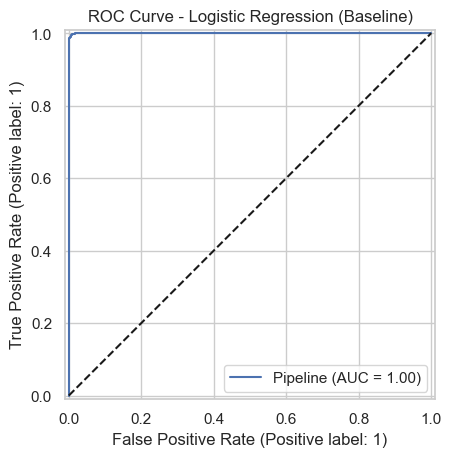

In [18]:
# Set sklearn to output pandas DataFrames so the ColumnTransformer can filter by column names
set_config(transform_output="pandas")

# Train-Test Split Based on Timestamp (Notice that a velocity fraud attack can not be split because they always happen from 2 AM to 7 AM)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
split_date = pd.Timestamp('2026-01-23')

mask_train = df['Timestamp'] < split_date
mask_test = df['Timestamp'] >= split_date

X_train = df.loc[mask_train].drop('Is_Fraud', axis=1)
y_train = df.loc[mask_train, 'Is_Fraud']

X_test = df.loc[mask_test].drop('Is_Fraud', axis=1)
y_test = df.loc[mask_test, 'Is_Fraud']

# Preparing the column lists for the column transformer
numeric_cols = [
    'Amount', 'Amount_Ratio', 'Avg_Ticket', 'Std_Ticket', 
    'Time_Since_Last', 'Transactions_Last_Hour',
    'Distance_to_Centroid_0', 'Distance_to_Centroid_1',
    'Distance_to_Centroid_2', 'Distance_to_Centroid_3'
]

categorical_cols = ['Category', 'Cluster_ID']

flag_cols = ['Is_Night', 'Is_Foreign', 'Is_Fixed']

# Column Transformer for Logistic Regression
column_linear = ColumnTransformer([
    # Scaling for numeric features
    ('num', StandardScaler(), numeric_cols),
    
    # One-Hot Encoding for categorical features (dropping first to avoid multicollinearity)
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
    
    # Flag features passed through without changes
    ('flags', 'passthrough', flag_cols)
], verbose_feature_names_out=False)

# Complete preprocessing pipeline for Logistic Regression
logit_pipeline = Pipeline([
    ('fraud_preprocessor', FraudPreprocessor(kmeans_pipeline=kmeans_pipeline)),
    ('col_transformer', column_linear),
    ('classifier', LogisticRegression(
        class_weight='balanced',  
        solver='liblinear',       
        random_state=SEED,
        max_iter=1000             
    ))
])

logit_pipeline.fit(X_train, y_train)

# Predict probabilities on the test set
y_prob = logit_pipeline.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
auc_score = roc_auc_score(y_test, y_prob)

print(f"Logistic Regression ROC-AUC Score: {auc_score:.4f}")

# Plot ROC Curve
RocCurveDisplay.from_estimator(logit_pipeline, X_test, y_test)
plt.title("ROC Curve - Logistic Regression (Baseline)")
plt.plot([0, 1], [0, 1], "k--", label="Azar (AUC = 0.5)")
plt.show()

As we feared, the baseline model achieved a near-perfect ROC-AUC score, implying that the distinction between fraudulent and legitimate transactions in this dataset is highly explicit and linearly separable.

While this clearly prooves the dataset lacks the noise often found in real-world scenarios, the feature importance analysis will give us a clear map of the 'fraud rules' currently at play. 

                    Feature    Weight  Abs_Weight
19                 Is_Night  6.752999    6.752999
13          Category_Retail  4.953798    4.953798
20               Is_Foreign  4.351431    4.351431
5    Transactions_Last_Hour  3.115617    3.115617
16             Cluster_ID_1 -1.883187    1.883187
18             Cluster_ID_3 -1.689635    1.689635
17             Cluster_ID_2 -1.491044    1.491044
12          Category_Others -1.420734    1.420734
11         Category_Leisure -1.312352    1.312352
14  Category_Transportation -1.200300    1.200300


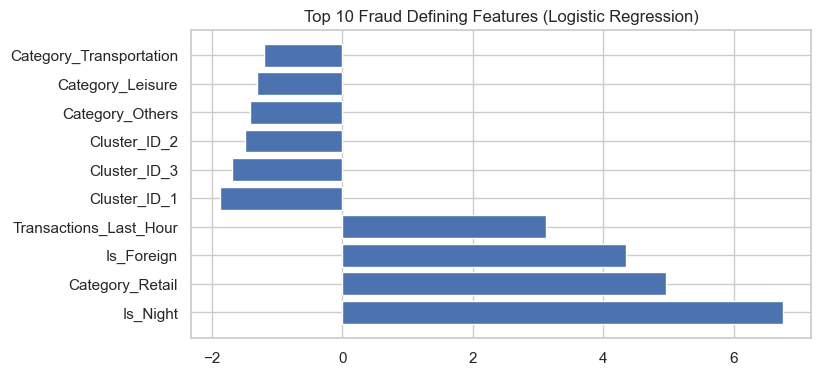

In [19]:
# Extracting and Visualizing Feature Importances from Logistic Regression
coeffs = pd.DataFrame({
    'Feature': logit_pipeline.named_steps['col_transformer'].get_feature_names_out(),
    'Weight': logit_pipeline.named_steps['classifier'].coef_[0]  
})

# Order by absolute value (Importance)
coeffs['Abs_Weight'] = coeffs['Weight'].abs()
coeffs = coeffs.sort_values('Abs_Weight', ascending=False).head(10)

# Display and plot the top 10 features
print(coeffs)
plt.figure(figsize=(8, 4))
plt.barh(coeffs['Feature'], coeffs['Weight'])
plt.title("Top 10 Fraud Defining Features (Logistic Regression)")
plt.show()

The Logistic Regression weights reveal the deterministic nature of the synthetic dataset:

The model is heavily dominated by static flags. `Is_Night` is the most decisive feature (~6.75), implying that virtually all fraud in this dataset occurs at night, followed closely by Retail purchases and Foreign transactions.

Crucially, `Transactions_Last_Hour` appears in the top 4 positive features (~3.11). This confirms that our feature engineering successfully captured the "velocity attack" pattern, even in a linear model.

Moving forward, we maintain our strategy to train the Main Model (XGBoost). This step remains effective to demonstrate that our feature engineering pipeline (`FraudPreprocessor`) is robust across different algorithm families, regardless of the dataset's simplicity.

### 4.2. Main Model (XGBoost)
Following the Logistic Regression analysis, we implement an XGBoost classifier.

It is important to note that this step is performed primarily for comparative analysis, rather than performance gain. Since the linear baseline already yielded a near-perfect ROC-AUC, we do not expect a significant jump in metric scores.

Instead, our goal is to extract the Feature Importance generated by the tree ensemble. By comparing these values with the coefficients from the linear model, we can validate whether the "fraud signal" remains consistent across different algorithms or if the non-linear approach uncovers different underlying patterns (such as behavioral anomalies) that the linear model might have oversimplified.

XGBoost ROC-AUC Score: 1.0000


<Figure size 800x600 with 0 Axes>

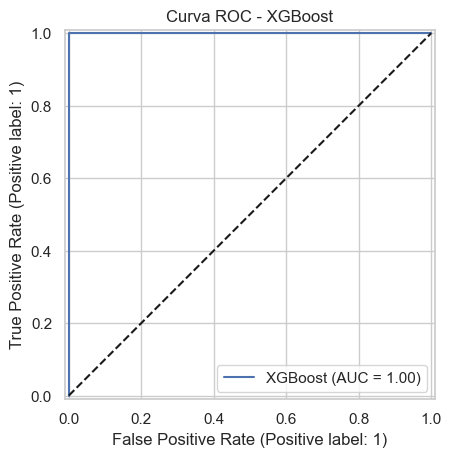

In [20]:
# Define the XGBoost Classifier Pipeline
xgb_pipeline = Pipeline([
    ('fraud_preprocessor', FraudPreprocessor(kmeans_pipeline=kmeans_pipeline)),
    ('col_transformer', encoder),
    ('classifier', XGBClassifier(
        n_estimators=100,       
        learning_rate=0.1,      
        max_depth=5,            
        scale_pos_weight=0.0668, # Fraud to Legitimate ratio computed in the EDA
        objective='binary:logistic',
        eval_metric='auc',      
        random_state=SEED,
        n_jobs=-1               
    ))
])

# Train the XGBoost pipeline
xgb_pipeline.fit(X_train, y_train)

# Predict probabilities on the test set
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score for XGBoost
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

print(f"XGBoost ROC-AUC Score: {auc_xgb:.4f}")

# Plot ROC Curve for XGBoost
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(xgb_pipeline, X_test, y_test, name="XGBoost")
plt.plot([0, 1], [0, 1], "k--", label="Azar (AUC = 0.5)")
plt.title("Curva ROC - XGBoost")
plt.show()

A Perfect Classification The XGBoost model achieved a ROC-AUC Score of 1.0. In real-world scenarios, a perfect score is practically impossible due to noise and human unpredictability. However, in this synthetic environment, this result confirms that the fraud generation logic is deterministic.

                   Feature  Importance
17  Transactions_Last_Hour    0.763534
16         Time_Since_Last    0.106553
13                    Hour    0.026690
11                  Amount    0.021281
1         Category_Housing    0.021084
14                Is_Night    0.015948
4          Category_Retail    0.011500
18              Is_Foreign    0.010435
19              Avg_Ticket    0.009415
12            Amount_Ratio    0.007395


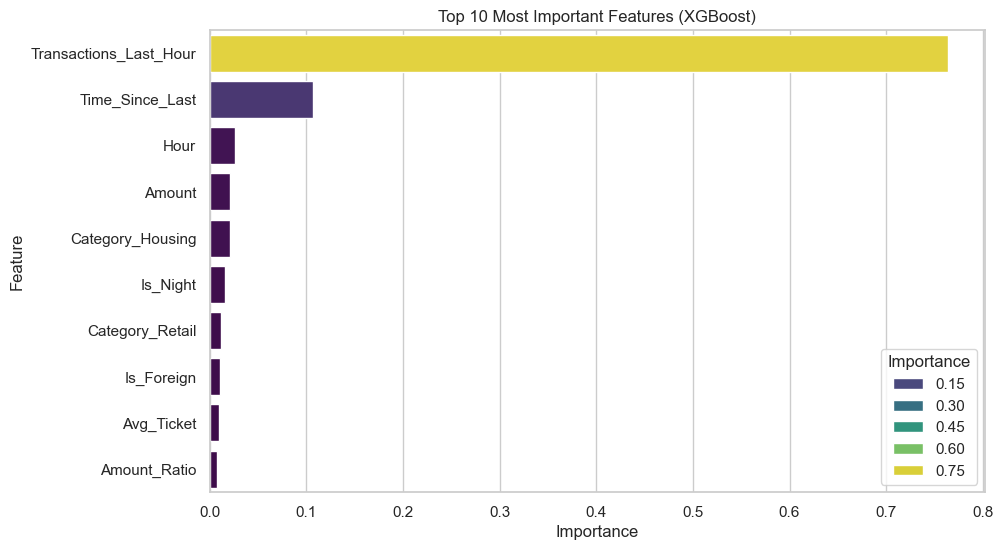

In [21]:
# Create DataFrame of Importance
importance = pd.DataFrame({
    'Feature': xgb_pipeline.named_steps['col_transformer'].get_feature_names_out(),
    'Importance': xgb_pipeline.named_steps['classifier'].feature_importances_
})

# Order and Plot Top 10 Features by Importance
importance = importance.sort_values('Importance', ascending=False).head(10)
print(importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis', hue='Importance')
plt.title('Top 10 Most Important Features (XGBoost)')
plt.show()

Coment on this and compare it to the logistic regression

Feature  Importance
17  Transactions_Last_Hour    0.763534
16         Time_Since_Last    0.106553
13                    Hour    0.026690
11                  Amount    0.021281
1         Category_Housing    0.021084
14                Is_Night    0.015948
4          Category_Retail    0.011500
18              Is_Foreign    0.010435
19              Avg_Ticket    0.009415
12            Amount_Ratio    0.007395

The XGBoost results represent a paradigm shift from the baseline. While the Logistic Regression relied on circumstantial evidence, the XGBoost model zeroed in on the actual attack mechanism.

| Feature Type | Logistic Regression (Linear) | XGBoost (Non-Linear) |
| :--- | :--- | :--- |
| **Top Driver** | `Is_Night` (Weight: 6.75) | `Transactions_Last_Hour` (Imp: 0.76) |
| **Logic** | Contextual / Circumstantial | Behavioral / Direct |
| **Interpretation** | The model relied on **proxies**. Night is associated with fraud, but night doesn't *cause* fraud. | The model found the **root cause**. The attack mechanism is high velocity (bots/scripts). |
| **Is_Night Role** | **#1 predictor.** The model clung to it because it separates data easily with a straight line. | **Irrelevant (1.5%).** Once the model knows the velocity, the time of day becomes redundant information. |

The fact that `Transactions_Last_Hour` captures 76% of the feature importance confirms that the fraud in this dataset is structurally defined by velocity attacks. Considering `Transactions_Last_Hour` and `Time_Since_Last` both combined explain 87% of the fraud. Everything else is statistically negligible noise to this model. The model effectively learned that speed matters, rendering contextual variables like time of day or category largely redundant. This is likely due to the volume of transactions, even though there was a near equal amount of attacks from both types, velocity attacks include 5 to 15 transactions, each flagged as Fraud.

## 5. Final Insights
We must address the elephant in the room: the results were disappointing in their perfection. Achieving an AUC of 1.0 with XGBoost (and 0.9997 with Logistic Regression) confirms that the synthetic dataset is trivial and highly deterministic. The fraud scenarios lacked the noise typical of real-world production data, turning the classification task into a straightforward rule-matching exercise.

However, even though the predictive challenge was nonexistent, the analytical value was significant. By probing why the models found the task so easy, we extracted conclusions into the nature of detection logic:

1. **The "Context vs. Behavior".** The most significant insight arose from comparing the decision logic of the two models.

    * Logistic Regression (Context): The linear model achieved near-perfect detection (AUC 0.9997) by relying on circumstantial proxies. It learned when fraud happens, but not necessarily how.

    * XGBoost (Behavior): The non-linear model achieved a perfect score (AUC 1.0) by discarding time-based proxies and focusing on behavioral mechanics.

2. **Validation of Feature Engineering.** The success of the XGBoost model validates the FraudPreprocessor pipeline. The raw data did not contain a "velocity" column; this was engineered. The fact that `Transactions_Last_Hour` became the single most important predictor confirms that feature engineering is more impactful than model selection. Without this engineered feature, the XGBoost model would have been forced to rely on weaker proxies like the linear model did.